# *------------------------------------------------------------------------------------------*

# AI-powered Fraud Detection System

# *------------------------------------------------------------------------------------------*

# Importing necessary libraries
# *------------------------------------------------------------------------------------------*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, roc_curve, auc, precision_recall_curve, 
    classification_report
)
import shap
import warnings
warnings.filterwarnings("ignore")

# *------------------------------------------------------------------------------------------*
# Loading the dataset
# *------------------------------------------------------------------------------------------*

In [44]:
data = pd.read_csv('creditcardprj2.csv')

# *------------------------------------------------------------------------------------------*
#  basic information
# *------------------------------------------------------------------------------------------*

In [46]:
print("Dataset Info:")
print(data.info())
print("\nFirst few rows of the dataset:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 

# *------------------------------------------------------------------------------------------*
# Check for missing values
# *------------------------------------------------------------------------------------------*

In [30]:
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


# *------------------------------------------------------------------------------------------*
# Scaling the 'Amount' column using StandardScaler
# *------------------------------------------------------------------------------------------*

In [48]:
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])

# *------------------------------------------------------------------------------------------*
# Spliting the data into features (X) and target (y)
# *------------------------------------------------------------------------------------------*

In [51]:
X = data.drop('Class', axis=1)
y = data['Class']

# *------------------------------------------------------------------------------------------*
# EDA: Target Distribution
# *------------------------------------------------------------------------------------------*

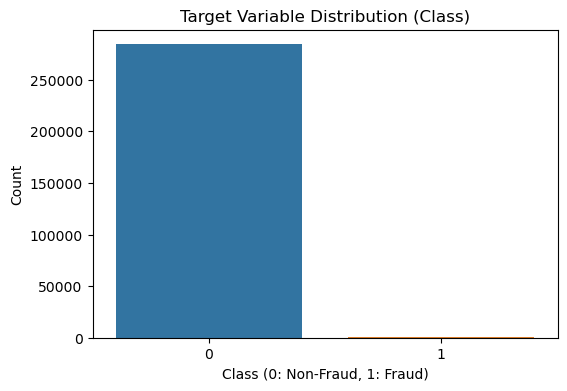

In [54]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=data)
plt.title("Target Variable Distribution (Class)")
plt.xlabel("Class (0: Non-Fraud, 1: Fraud)")
plt.ylabel("Count")
plt.show()

# *------------------------------------------------------------------------------------------*
# Distribution of 'Amount' by Class
# *------------------------------------------------------------------------------------------*

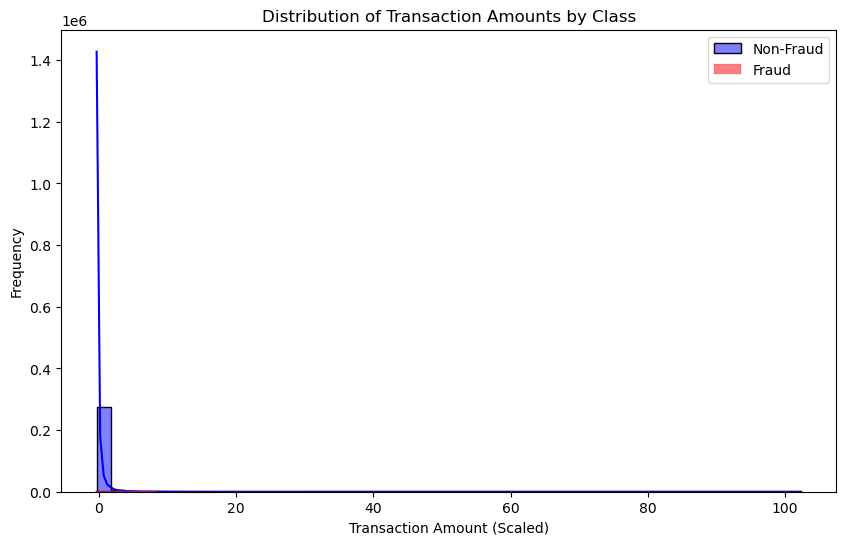

In [59]:
plt.figure(figsize=(10, 6))
sns.histplot(data[data['Class'] == 0]['Amount'], bins=50, color="blue", kde=True, label="Non-Fraud")
sns.histplot(data[data['Class'] == 1]['Amount'], bins=50, color="red", kde=True, label="Fraud")
plt.title("Distribution of Transaction Amounts by Class")
plt.xlabel("Transaction Amount (Scaled)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# *------------------------------------------------------------------------------------------*
# Correlation of  Heatmap
# *------------------------------------------------------------------------------------------*

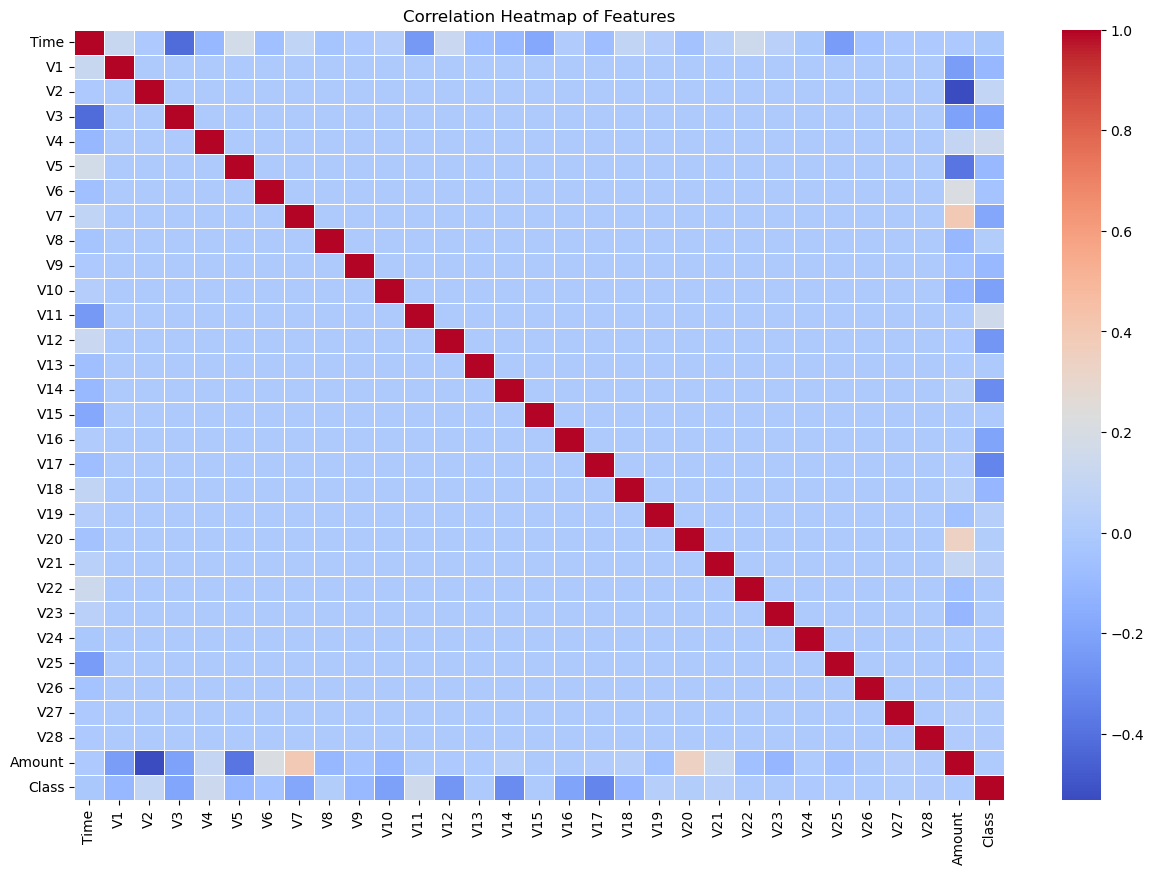

In [61]:
plt.figure(figsize=(15, 10))
corr = data.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()


# *------------------------------------------------------------------------------------------*
# PCA Analysis for Dimensionality Reduction
# *------------------------------------------------------------------------------------------*

In [63]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
data_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
data_pca['Class'] = y

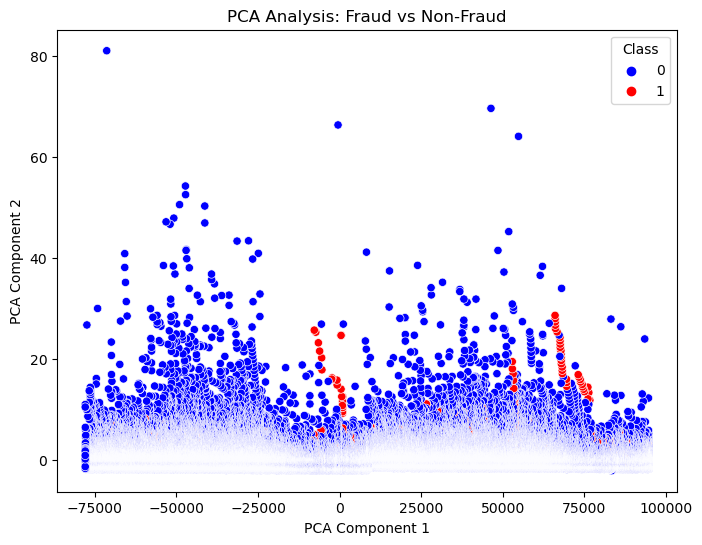

In [64]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Class", data=data_pca, palette=["blue", "red"])
plt.title("PCA Analysis: Fraud vs Non-Fraud")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# *------------------------------------------------------------------------------------------*
# Boxplot for detecting outliers in transaction amounts by class
# *------------------------------------------------------------------------------------------*

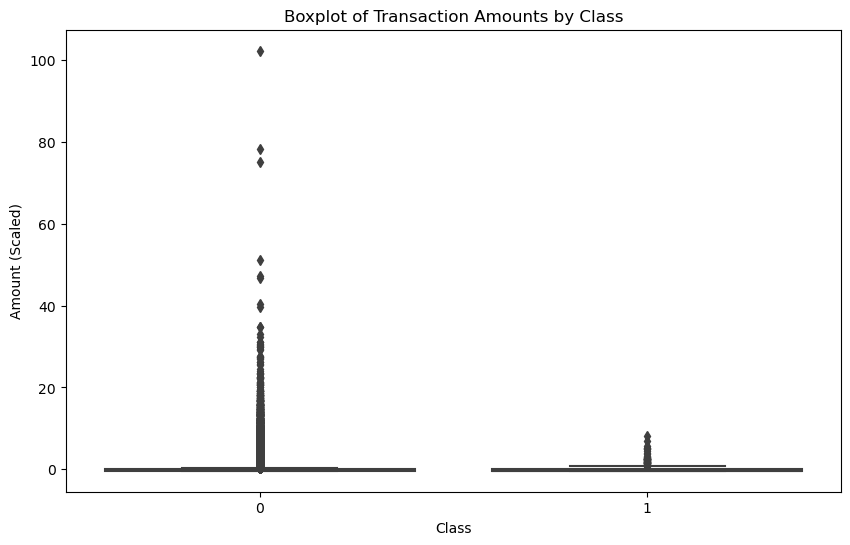

In [66]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=data)
plt.title("Boxplot of Transaction Amounts by Class")
plt.xlabel("Class")
plt.ylabel("Amount (Scaled)")
plt.show()

# *------------------------------------------------------------------------------------------*
# Train-Test Split
# *------------------------------------------------------------------------------------------*

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nData split completed. Training set size:", X_train.shape, "Testing set size:", X_test.shape)


Data split completed. Training set size: (227845, 30) Testing set size: (56962, 30)


# *------------------------------------------------------------------------------------------*
# Initialize the Random Forest Classifier with GridSearch for hyperparameter tuning
# *------------------------------------------------------------------------------------------*

In [14]:
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10]
}

In [15]:
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=1)

# *------------------------------------------------------------------------------------------*
# Train the model with GridSearchCV
# *------------------------------------------------------------------------------------------*

In [16]:
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


# *------------------------------------------------------------------------------------------*
# Best parameters found
# *------------------------------------------------------------------------------------------*

In [17]:
print("\nBest parameters for Random Forest:", grid_search.best_params_)


Best parameters for Random Forest: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}


# *------------------------------------------------------------------------------------------*
# Evaluate the model on the testing set
# *------------------------------------------------------------------------------------------*

In [18]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# *------------------------------------------------------------------------------------------*
# Detailed Classification Report
# *------------------------------------------------------------------------------------------*

In [19]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.81      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



# *------------------------------------------------------------------------------------------*
# Confusion Matrix with Heatmap
# *------------------------------------------------------------------------------------------*

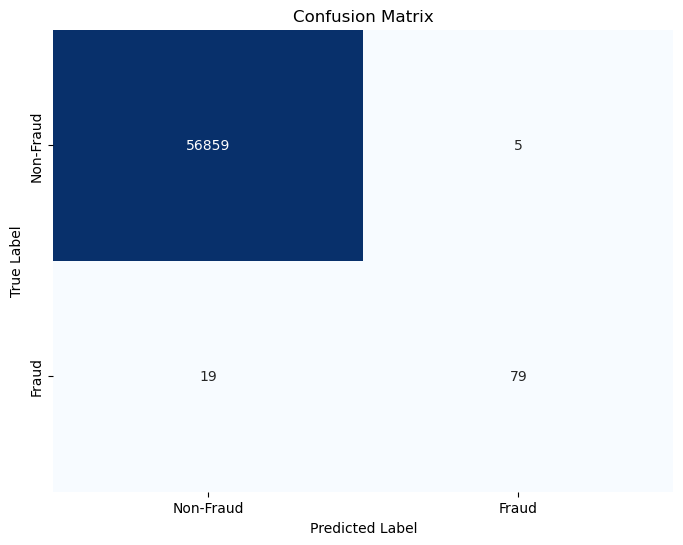

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# *------------------------------------------------------------------------------------------*
# Precision-Recall Curve
# *------------------------------------------------------------------------------------------*

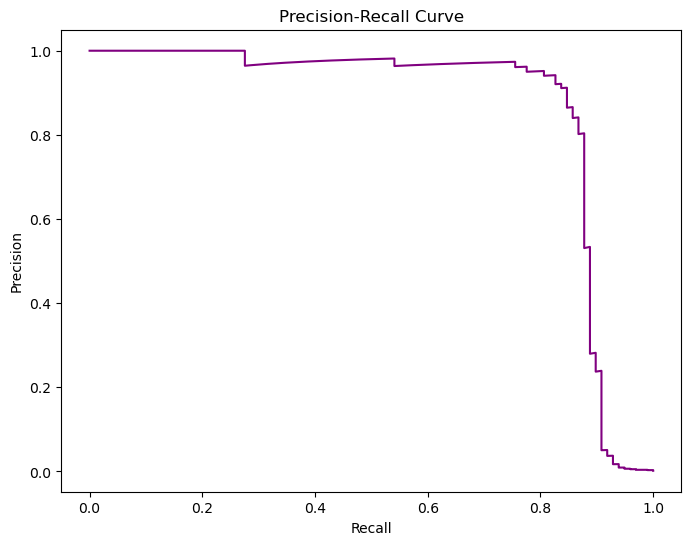

In [21]:
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# *------------------------------------------------------------------------------------------*
# ROC Curve
# *------------------------------------------------------------------------------------------*

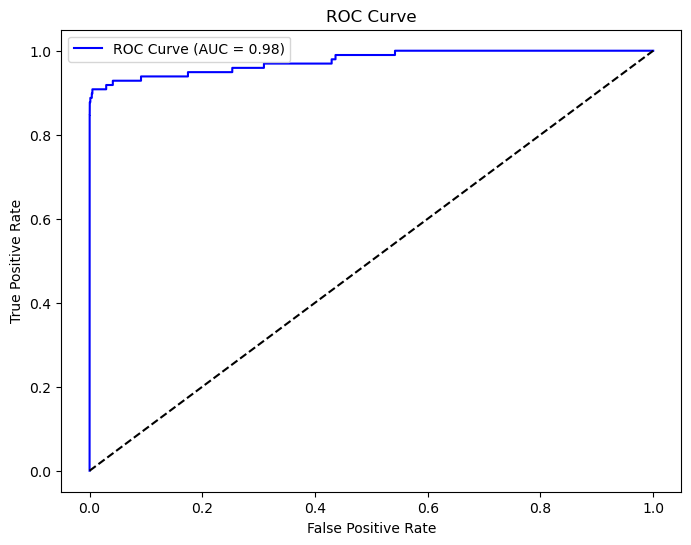

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# *------------------------------------------------------------------------------------------*
# SHAP values for interpretability of features
# *------------------------------------------------------------------------------------------*

<Figure size 1200x600 with 0 Axes>

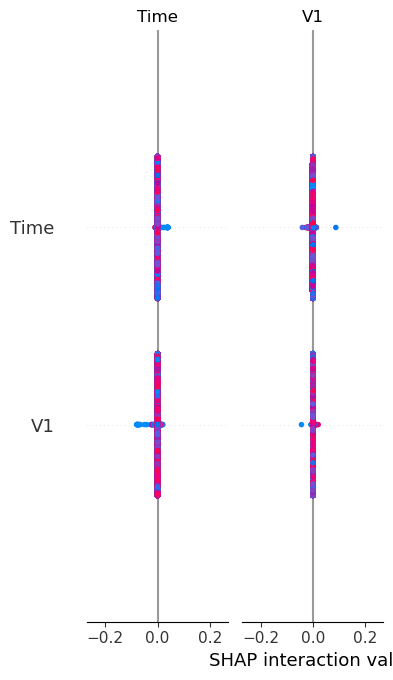

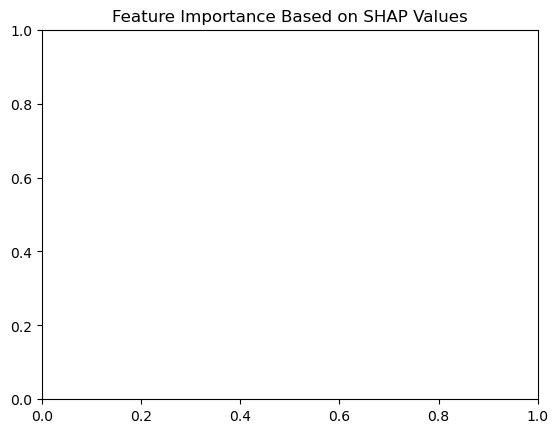

In [25]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)

if hasattr(shap_values, "values"):
    shap_values = shap.Explanation(values=shap_values.values, base_values=shap_values.base_values, data=X_test)

plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns)
plt.title("Feature Importance Based on SHAP Values")
plt.show()


# *------------------------------------------------------------------------------------------*
# Summary SHAP Plot
# *------------------------------------------------------------------------------------------*

# *------------------------------------------------------------------------------------------*
# Saving the best model
# *------------------------------------------------------------------------------------------*

In [28]:
import joblib
joblib.dump(best_model, 'fraud_detection_model.pkl')

['fraud_detection_model.pkl']